Ref:
1. Pandas Wrangling
    https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf
2. 空污地圖實作發表文章
    https://tanet2019.nsysu.edu.tw/assets/TANET2019_thesis/E3_018.pdf
3. 直轄市、縣市界線(TWD97經緯度)
    https://data.gov.tw/dataset/7442
4. 鄉鎮市區界線(TWD97經緯度)
    https://data.gov.tw/dataset/7441
5. Online map loading
    https://mapshaper.org/?fbclid=IwAR2zcqizx7qxQW-QFgsDoYbmNchTuTvkeqQn96ls5Qm1WOCYDBEZx9_aCbU
6. 用_GeoPandas_畫出生動的色塊地圖
    https://mosdeo.github.io/2017/08/10/2017_0810_用_GeoPandas_畫出生動的色塊地圖/
7. Python 練習: 以地圖顯示癌症死因資料(II)
    http://viml.nchc.org.tw/blog/paper_info.php?CLASS_ID=1&SUB_ID=1&PAPER_ID=687
8. pycon16 geopandas
    https://nbviewer.jupyter.org/github/nispc/pycon2016-geoPandas/tree/master/
9. Geopandas doc
    https://geopandas.org/io.html
10. Polygon grids
    https://gis.stackexchange.com/questions/269243/creating-polygon-grid-using-geopandas
11. Polygon grids
    https://stackoverflow.com/questions/55199436/generate-grid-of-latitude-longitude-coordinates-that-fall-within-polygon

In [1]:
#pip install geopandas
#pip install descartes
#pip install rasterio
#pip install pygeos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import descartes
import shapely
from shapely.geometry import Polygon

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## load the TOWN.shp to get rid of the outlying islands and sea

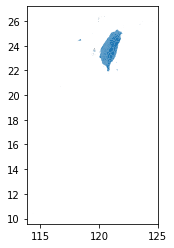

In [3]:
#county_shp = gp.read_file("MapData/COUNTY/COUNTY_MOI_1090820.shp")
town_shp = gp.read_file("MapData/TOWN/TOWN_MOI_1090820.shp", encoding='utf-8')

# check the crs (coordinate system)
town_shp.crs
town_shp.plot()

In [4]:
town_shp = town_shp[['COUNTYNAME','TOWNNAME', 'geometry']]
#print(town_shp)

In [5]:
kaohsiung = town_shp.loc[town_shp['COUNTYNAME']=="高雄市", ['TOWNNAME', 'geometry']]
Qijin_geo = kaohsiung.explode().loc[320].loc[16].values[-1]
#print(Qijin.values[-1])

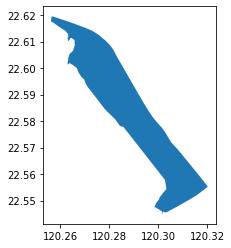

In [6]:
town_shp.loc[town_shp['TOWNNAME']=="旗津區", 'geometry'] = Qijin_geo
town_shp.loc[town_shp['TOWNNAME']=="旗津區", 'geometry'].plot()

In [7]:
taitung = town_shp.loc[town_shp['COUNTYNAME']=="臺東縣", ['TOWNNAME', 'geometry']]
town_shp.drop([3,4], axis=0, inplace=True)

In [8]:
pintung = town_shp.loc[town_shp['COUNTYNAME']=="屏東縣", ['TOWNNAME', 'geometry']]
town_shp.drop(130, axis=0, inplace=True)
print(pintung.loc[126])

TOWNNAME                                                  內埔鄉
geometry    POLYGON ((120.6494528930001 22.71066898300006,...
Name: 126, dtype: object


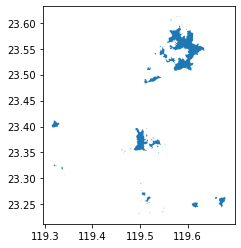

In [9]:
ponghu = town_shp.loc[town_shp['COUNTYNAME']=="澎湖縣", ['TOWNNAME', 'geometry']]
ponghu = ponghu.loc[ponghu['TOWNNAME'] == '馬公市'].append(ponghu.loc[ponghu['TOWNNAME'] == '望安鄉'])
i = ponghu.loc[ponghu['TOWNNAME'] == '望安鄉'].index[0]
u = ponghu.loc[ponghu['TOWNNAME'] == '馬公市'].index[0]
ponghu = town_shp.loc[[i, u]]
ponghu.plot()

### Clip out sothern Taiwan area only

In [10]:
county = ['高雄市', '嘉義市', '嘉義縣', '臺南市', '屏東縣', '臺東縣']
town_shp = pd.concat([town_shp.loc[town_shp['COUNTYNAME']==i] for i in county], ignore_index=True)
#town_shp = pd.concat([town_shp, ponghu])

In [11]:
town_shp.index = range(len(town_shp))
#town_shp

In [12]:
long_w = town_shp.total_bounds[0]
long_e = town_shp.total_bounds[2]
lat_n = town_shp.total_bounds[3]
lat_s = 21.89

# the geometry used for clipping
polygon = Polygon([(long_w, lat_s), (long_w, lat_n), (long_e, lat_n), (long_e, lat_s), (long_w, lat_s)])
poly_gdf = gp.GeoDataFrame(geometry=[polygon], crs=town_shp.crs)
print(poly_gdf.total_bounds)

[120.02690557  21.89       121.49609509  23.63591295]


[120.02690557  21.89559968 121.49609509  23.63591295]


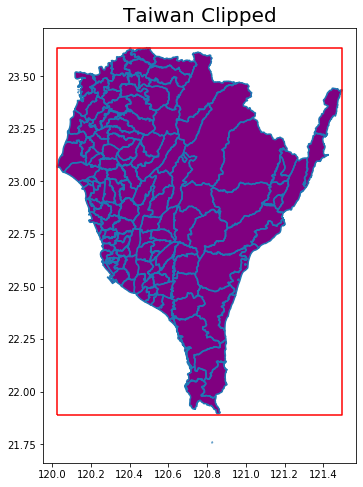

In [13]:
#gp.GeoDataFrame({'geometry':county_shp['geometry'].intersection(polygon).unary_un5ion}, crs=county_shp.crs).total_bounds
taiwan_clip = gp.clip(town_shp, polygon, True)
print(taiwan_clip.total_bounds)

# Plot the clipped data
# The plot below shows the results of the clip function applied to the taiwan
fig, ax = plt.subplots(figsize=(12, 8))
taiwan_clip.plot(ax=ax, color="purple")
town_shp.boundary.plot(ax=ax)
poly_gdf.boundary.plot(ax=ax, color="red")
ax.set_title("Taiwan Clipped", fontsize=20)
plt.show()

## Create grids on the map

width: 10
length: 10
[120.02690557  21.89       121.49609509  23.63591295]
long_w: 120.02690556700009, lat_s: 21.89, long_e: 121.49609509200002, lat_n: 23.63591295300006


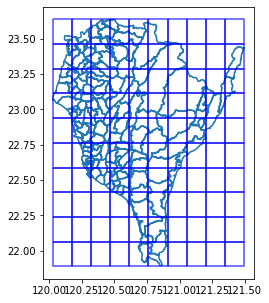

In [14]:
# total cells in the grid: 10x10
long_span = 11
lat_span = 11

cols = np.linspace(long_w, long_e, long_span)
rows = np.flip(np.linspace(lat_s, lat_n, lat_span))

# create polygons of cells
polygons = []
for long in range(len(cols)):
    if long+1 < len(cols):
        for lat in range(len(rows)):
            if lat+1 < len(rows):
                polygons.append(Polygon([(cols[long], rows[lat]), (cols[long+1], rows[lat]), (cols[long+1], rows[lat+1]), (cols[long], rows[lat+1])]))

grid = gp.GeoDataFrame({'geometry':polygons}, crs=town_shp.crs)

assert tuple(grid.total_bounds) == tuple([long_w, lat_s, long_e, lat_n])

print(f'width: {len(cols)-1}')
print(f'length: {len(rows)-1}')
print(grid.total_bounds)
print(f'long_w: {long_w}, lat_s: {lat_s}, long_e: {long_e}, lat_n: {lat_n}')

grid.to_file("./MapData/grid.shp")

fig, ax = plt.subplots(figsize=(5, 5))
grid.boundary.plot(ax=ax, color='b', alpha=0.7, zorder=2)
taiwan_clip.boundary.plot(ax=ax, zorder=1)
plt.show()

## Remain the boundary of counties only to save the processing time

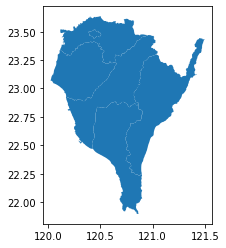

In [20]:
taiwan_clip = taiwan_clip.dissolve(by='COUNTYNAME')
taiwan_clip.to_file("./MapData/taiwan_contour.shp")
taiwan_clip.plot()

## Clip the Taiwan_grid and Taiwan_offgrid

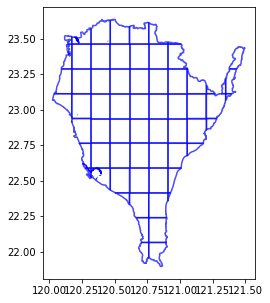

In [21]:
#taiwan_grid = gp.overlay(grid, taiwan_clip, how='intersection')
taiwan_grid = gp.clip(grid, taiwan_clip)

fig, ax = plt.subplots(figsize=(5, 5))
taiwan_grid.boundary.plot(ax=ax, color='b', alpha=0.7)
plt.show()

In [22]:
assert taiwan_grid.crs == town_shp.crs
taiwan_grid.to_file("./MapData/taiwan_grid.shp")

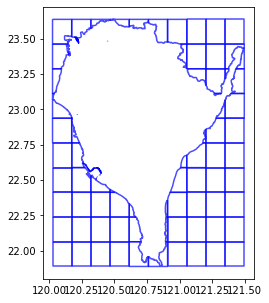

In [23]:
taiwan_offgrid = gp.overlay(grid, taiwan_clip, how='difference')

fig, ax = plt.subplots(figsize=(5, 5))
taiwan_offgrid.boundary.plot(ax=ax, color='b', alpha=0.7)
plt.show()

In [24]:
assert taiwan_offgrid.crs == town_shp.crs
taiwan_offgrid.to_file("./MapData/taiwan_offgrid.shp")